# Feature Engineering

In this notebook, we will convert our data and create a feature matrix so we can feed this to our model

We will do some EDA on the dataset at the end to determine which ML model we will use

## Features

* filter out any users that are within 7 days of the end of our report since these users will most likely not qualify and might skew our model
* creation_source - one hot encode
* opted_in_to_mailing_list - leave as is (0/1)
* enabled_for_marketing_drip - leave as is (0/1)
* org_id - one hot encode
* invited_by_user_id
    * invited - indicates whether user was invited or not (0/1)
* creation_time - split into month and year
* engagements_first_30 - create this to represent number of engagements by users within the first 30 day of account creation
* days_to_first_engagement - create this
* adopted - create
* drop unused columns
    * last_session_creation_time
    * name
    * object_id
    * email
    * invited_by_user_id
    * org_id
    * creation_source
    * creation_time
    

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
import pickle

%matplotlib inline
sns.set(font_scale=2)


adoped_user_file = "adopted_users.csv"


In [2]:
# load both files and sort by values
users_orig = pd.read_csv("takehome_users.csv", 
                    encoding="latin8", 
                    parse_dates=["creation_time"]).sort_values("creation_time", 
                                                               ascending=True)
engagement_orig = pd.read_csv("takehome_user_engagement.csv", 
                         encoding="latin8", 
                         parse_dates=["time_stamp"]).sort_values("time_stamp",
                                                                ascending=True)

In [3]:
users_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 3860 to 6052
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 1.0+ MB


In [4]:
engagement_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 178140 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3 MB


# Filter Out Users Created Within 7 Days of End of Our Report

These uses will most likely not qualify and might skew our data

In [5]:
engagement_orig.time_stamp.max()

Timestamp('2014-06-06 14:58:50')

In [6]:
# drop users created after this
engagement_orig.time_stamp.max() - pd.Timedelta(weeks = 1)

Timestamp('2014-05-30 14:58:50')

#### Looks like there are 28 users that fit this profile

In [7]:
users_orig[users_orig.creation_time >= 
           engagement_orig.time_stamp.max() - pd.Timedelta(weeks = 1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 6421 to 6052
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   28 non-null     int64         
 1   creation_time               28 non-null     datetime64[ns]
 2   name                        28 non-null     object        
 3   email                       28 non-null     object        
 4   creation_source             28 non-null     object        
 5   last_session_creation_time  23 non-null     float64       
 6   opted_in_to_mailing_list    28 non-null     int64         
 7   enabled_for_marketing_drip  28 non-null     int64         
 8   org_id                      28 non-null     int64         
 9   invited_by_user_id          15 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 2.4+ KB


#### We should have 11972 users left

In [8]:
users = users_orig.drop(users_orig[users_orig.creation_time >= 
                                   engagement_orig.time_stamp.max() - pd.Timedelta(weeks = 1)].index, 
           axis=0)
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11972 entries, 3860 to 7162
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   11972 non-null  int64         
 1   creation_time               11972 non-null  datetime64[ns]
 2   name                        11972 non-null  object        
 3   email                       11972 non-null  object        
 4   creation_source             11972 non-null  object        
 5   last_session_creation_time  8800 non-null   float64       
 6   opted_in_to_mailing_list    11972 non-null  int64         
 7   enabled_for_marketing_drip  11972 non-null  int64         
 8   org_id                      11972 non-null  int64         
 9   invited_by_user_id          6402 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 1.0+ MB


# Encode Feature Columns

* creation_source - one hot encode
* org_id - one hot encode

In [9]:
users.creation_source = users.creation_source.str.lower()


users = pd.concat([users, pd.get_dummies(users.creation_source, prefix='cs')],axis=1)

cs_cols = [i for i in users.columns if i.startswith("cs_")]
cs_cols.append("creation_source")
users[cs_cols].sample(10)

,cs_guest_invite,cs_org_invite,cs_personal_projects,cs_signup,cs_signup_google_auth,creation_source
10348,0,0,0,0,1,signup_google_auth
6889,0,0,0,1,0,signup
5494,0,1,0,0,0,org_invite
6950,0,0,0,1,0,signup
7525,0,0,1,0,0,personal_projects
10018,0,1,0,0,0,org_invite
4324,0,1,0,0,0,org_invite
10950,1,0,0,0,0,guest_invite
4222,0,1,0,0,0,org_invite
11350,0,1,0,0,0,org_invite


In [10]:
users = pd.concat([users, pd.get_dummies(users.org_id, prefix='org_id')],axis=1)
oid_cols = [i for i in users.columns if i.startswith("org_id_")]
oid_cols.append("org_id")
users[oid_cols].sample(10)

,org_id_0,org_id_1,org_id_2,org_id_3,org_id_4,org_id_5,org_id_6,org_id_7,org_id_8,org_id_9,...,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416,org_id
7506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,50
4967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,145
8516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,154
7202,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,202
7948,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,256
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,331
9478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
9480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,388
9521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
2153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,54


# Convert invited_by_user_id to binary

In [11]:
users["invited"] = np.where(users.invited_by_user_id.isnull(), 0, 1)
users[["invited_by_user_id", "invited"]].sample(10)

,invited_by_user_id,invited
31,NaN,0
8973,NaN,0
4510,3918.0,1
3015,NaN,0
6152,5929.0,1
3004,NaN,0
11818,1512.0,1
7025,10308.0,1
9744,11750.0,1
2324,6405.0,1


# Split creation_time into month and year then encode

In [12]:
users["creation_month"] = users.creation_time.dt.month
users["creation_year"] = users.creation_time.dt.year

In [13]:
users = pd.concat([users, pd.get_dummies(users.creation_month, prefix='cm')],axis=1)
cm_cols = [i for i in users.columns if i.startswith("cm_")]
cm_cols.append("creation_time")
users[cm_cols].sample(10)

,cm_1,cm_2,cm_3,cm_4,cm_5,cm_6,cm_7,cm_8,cm_9,cm_10,cm_11,cm_12,creation_time
7570,0,0,0,0,0,0,1,0,0,0,0,0,2013-07-25 12:09:25
5249,0,0,0,0,0,0,1,0,0,0,0,0,2012-07-13 05:12:14
4771,0,0,1,0,0,0,0,0,0,0,0,0,2014-03-26 09:01:45
5652,0,0,0,0,0,0,1,0,0,0,0,0,2013-07-25 21:25:47
4237,0,0,0,0,1,0,0,0,0,0,0,0,2013-05-01 11:56:55
2081,0,0,0,0,0,0,1,0,0,0,0,0,2013-07-02 23:06:45
6517,0,0,0,1,0,0,0,0,0,0,0,0,2014-04-02 08:12:11
8577,0,0,0,0,0,0,0,1,0,0,0,0,2013-08-01 14:30:58
2075,1,0,0,0,0,0,0,0,0,0,0,0,2014-01-02 15:46:43
5725,0,0,1,0,0,0,0,0,0,0,0,0,2014-03-23 16:44:34


In [14]:
users = pd.concat([users, pd.get_dummies(users.creation_year, prefix='cy')],axis=1)
cy_cols = [i for i in users.columns if i.startswith("cy_")]
cy_cols.append("creation_time")
users[cy_cols].sample(10)

,cy_2012,cy_2013,cy_2014,creation_time
7936,0,0,1,2014-01-22 11:54:18
1835,0,1,0,2013-06-16 12:09:34
9962,0,1,0,2013-08-02 21:11:41
3048,0,1,0,2013-10-04 21:23:09
2010,0,1,0,2013-01-18 17:54:53
1321,0,0,1,2014-04-19 10:59:52
4778,0,1,0,2013-10-04 23:10:53
1466,0,1,0,2013-10-13 16:43:15
365,0,0,1,2014-05-07 01:16:30
2406,0,0,1,2014-04-02 07:57:06


# Engagement Features

We will create the following features

* engagements_first_30 - create this to represent number of engagements by users within the first 30 day of account creation
* days_to_first_engagement - create this

In [15]:
users["engagements_first_30"] = users.apply(lambda x: 
                                            len(engagement_orig[(engagement_orig.user_id == x.object_id) & 
                                                           (engagement_orig.time_stamp < x.creation_time + pd.Timedelta(days=30))])
                                            , axis=1)
users[["object_id", "engagements_first_30"]].sample(10)

,object_id,engagements_first_30
3941,3942,0
121,122,0
2500,2501,0
605,606,0
501,502,3
5966,5967,0
11779,11780,1
10830,10831,1
9796,9797,1
6165,6166,0


In [16]:
# Check user 985 - there should be 4 engagements
user_id = 985
user_985 = users[users.object_id == user_id]

print(f'Before date: {user_985.creation_time + pd.Timedelta(days=30)}')
engagement_orig[(engagement_orig.user_id == user_id) ].head(5)


Before date: 984   2012-12-29 02:50:07
Name: creation_time, dtype: datetime64[ns]


,time_stamp,user_id,visited
16618,2012-11-30 02:50:07,985,1
16619,2012-12-02 02:50:07,985,1
16620,2012-12-06 02:50:07,985,1
16621,2012-12-21 02:50:07,985,1
16622,2013-01-27 02:50:07,985,1


In [17]:
# Check user 6013 - there should be 0 engagements
user_id = 6013
user_6013 = users[users.object_id == user_id]

print(f'Before date: {user_6013.creation_time + pd.Timedelta(days=30)}')
engagement_orig[(engagement_orig.user_id == user_id) ].head(5)


Before date: 6012   2013-07-19 11:10:28
Name: creation_time, dtype: datetime64[ns]


,time_stamp,user_id,visited


### Days to First Engagement

In [18]:
users["days_to_first_engagement"] = users.apply(lambda x: 
                                                (engagement_orig[engagement_orig.user_id == x.object_id].time_stamp.min() -
                                                x.creation_time).days
                                                , axis=1)


users[["object_id", "days_to_first_engagement"]].sample(10)

,object_id,days_to_first_engagement
5258,5259,0.0
3655,3656,2.0
9965,9966,4.0
8094,8095,2.0
6590,6591,0.0
11462,11463,0.0
34,35,NaN
983,984,0.0
224,225,2.0
3305,3306,0.0


In [19]:
# Check user 5746 - this user never logged in
user_id = 5746
print(f'User Creation Date: {users[users.object_id == user_id].creation_time}')
engagement_orig[engagement_orig.user_id == user_id].head(5)

User Creation Date: 5745   2013-07-29 16:50:48
Name: creation_time, dtype: datetime64[ns]


,time_stamp,user_id,visited


In [20]:
# Check user 11131 - this user logged in within 2 days
user_id = 11131
print(f'User Creation Date: {users[users.object_id == user_id].creation_time}')
engagement_orig[engagement_orig.user_id == user_id].head(5)

User Creation Date: 11130   2013-05-16 16:12:40
Name: creation_time, dtype: datetime64[ns]


,time_stamp,user_id,visited
195953,2013-05-18 16:12:40,11131,1


In [21]:
# Check user 10012 - this user loged in on the same day as creation
user_id = 10012
print(f'User Creation Date: {users[users.object_id == user_id].creation_time}')
engagement_orig[engagement_orig.user_id == user_id].head(5)

User Creation Date: 10011   2012-05-31 08:20:06
Name: creation_time, dtype: datetime64[ns]


,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1


### Days to Engage

* users either login within 14 day or they don't
* 

In [22]:
users.days_to_first_engagement.describe()

count    8800.000000
mean        1.002955
std         1.402428
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: days_to_first_engagement, dtype: float64

In [23]:
dte = users[["object_id","days_to_first_engagement"]].groupby("days_to_first_engagement").count(). \
                        rename({"object_id": "total"}, axis=1). \
                        reset_index()
dte["dte_percentage"] = dte.total / dte.total.sum()
dte

,days_to_first_engagement,total,dte_percentage
0,0.0,4336,0.492727
1,1.0,2261,0.256932
2,2.0,1124,0.127727
3,3.0,541,0.061477
4,4.0,258,0.029318
5,5.0,140,0.015909
6,6.0,81,0.009205
7,7.0,29,0.003295
8,8.0,18,0.002045
9,9.0,4,0.000455


In [24]:
users[users.days_to_first_engagement == 0].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,...,cm_8,cm_9,cm_10,cm_11,cm_12,cy_2012,cy_2013,cy_2014,engagements_first_30,days_to_first_engagement
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,org_invite,1.338452e+09,0,1,225,7104.0,...,0,0,0,0,0,1,0,0,1,0.0
3427,3428,2012-05-31 15:47:36,Spears Arthur,ArthurJSpears@gmail.com,signup_google_auth,1.352822e+09,1,0,166,NaN,...,0,0,0,0,0,1,0,0,2,0.0
9898,9899,2012-05-31 17:19:37,Jørgensen Sofie,SofieNJrgensen@yahoo.com,org_invite,1.338485e+09,0,0,138,9899.0,...,0,0,0,0,0,1,0,0,1,0.0
1692,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,signup_google_auth,1.399932e+09,0,1,50,NaN,...,0,0,0,0,0,1,0,0,9,0.0
6101,6102,2012-06-01 00:17:30,Morrison Natasha,NatashaMorrison@gustr.com,org_invite,1.339719e+09,0,0,34,6102.0,...,0,0,0,0,0,1,0,0,2,0.0


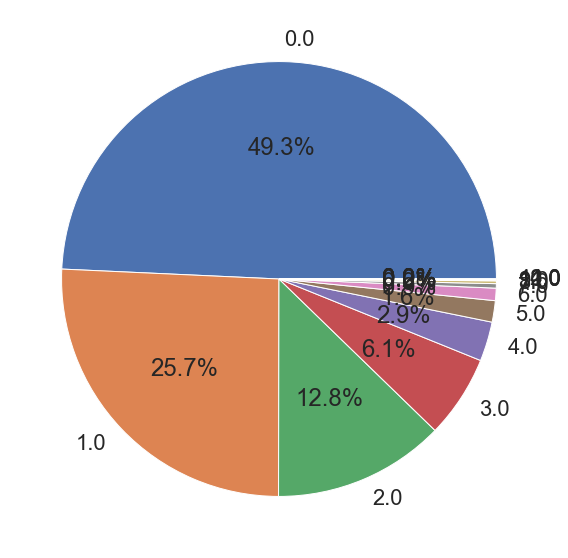

In [25]:
f, a = plt.subplots(1, 1, figsize=(10, 10))
_ = a.pie(dte.dte_percentage, labels=dte.days_to_first_engagement,
         autopct="%1.1f%%")

#### If we count up to 3 days, this accounts for 90+% of users that logged in - seems to be a resonable bin

In [26]:
# impute some large value for users that never logged in - NaN
users.days_to_first_engagement = users.days_to_first_engagement.fillna(100).astype(int)
users["days_to_first_engagement_bins"] = \
            pd.cut(users.days_to_first_engagement, 
                   bins=[0, 1, 2, 3, 14, users.days_to_first_engagement.max() + 1],
                  right=False)
users[["days_to_first_engagement", "days_to_first_engagement_bins"]].sample(10)

,days_to_first_engagement,days_to_first_engagement_bins
6847,2,"[2, 3)"
115,0,"[0, 1)"
7448,0,"[0, 1)"
11635,2,"[2, 3)"
6110,0,"[0, 1)"
1968,0,"[0, 1)"
1631,6,"[3, 14)"
10497,2,"[2, 3)"
11859,100,"[14, 101)"
8594,1,"[1, 2)"


In [27]:
users = pd.concat([users, pd.get_dummies(users.days_to_first_engagement_bins, prefix='dte')],axis=1)
dte_cols = [i for i in users.columns if i.startswith("dte_")]
dte_cols.append("days_to_first_engagement")
dte_cols.append("days_to_first_engagement_bins")
users[dte_cols].sample(10)

,"dte_[0, 1)","dte_[1, 2)","dte_[2, 3)","dte_[3, 14)","dte_[14, 101)",days_to_first_engagement,days_to_first_engagement_bins
10705,0,0,0,0,1,100,"[14, 101)"
9665,1,0,0,0,0,0,"[0, 1)"
3641,1,0,0,0,0,0,"[0, 1)"
4134,0,0,0,0,1,100,"[14, 101)"
3665,0,0,0,0,1,100,"[14, 101)"
4285,1,0,0,0,0,0,"[0, 1)"
7213,0,0,0,0,1,100,"[14, 101)"
5301,1,0,0,0,0,0,"[0, 1)"
5413,1,0,0,0,0,0,"[0, 1)"
5861,1,0,0,0,0,0,"[0, 1)"


# Adopted User Label

We already created this in our EDA notebook, let's merge it into our Dataframe

In [28]:
adopted_users = pd.read_csv("adopted_users.csv")

users = users.merge(adopted_users, 
                    how="left",
                left_on="object_id", 
                    right_on="user_id")

users["adopted"] = users.adopted.fillna(0).astype(int)

In [29]:
users[["object_id", "adopted"]].sample(10)

,object_id,adopted
11825,6472,0
4448,5851,0
196,4202,0
5332,8258,1
4085,5183,0
246,6171,1
10097,5726,1
15,4400,0
8975,2273,0
2390,9003,0


# Drop Unused Columns

* last_session_creation_time
* name
* object_id
* email
* invited_by_user_id
* org_id
* creation_source
* creation_time

In [30]:
# drop original columns we don't use
drop_cols = ["last_session_creation_time", "name", "object_id", "email", "invited_by_user_id",
             "org_id", "creation_source", "creation_time"
            ]

# drop intermediate columns
drop_cols += ["creation_month", "creation_year", "days_to_first_engagement", 
             "days_to_first_engagement_bins", "user_id"]

drop_cols

['last_session_creation_time',
 'name',
 'object_id',
 'email',
 'invited_by_user_id',
 'org_id',
 'creation_source',
 'creation_time',
 'creation_month',
 'creation_year',
 'days_to_first_engagement',
 'days_to_first_engagement_bins',
 'user_id']

In [31]:
users = users.drop(drop_cols, axis=1)
users.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,cs_guest_invite,cs_org_invite,cs_personal_projects,cs_signup,cs_signup_google_auth,org_id_0,org_id_1,org_id_2,...,cy_2012,cy_2013,cy_2014,engagements_first_30,"dte_[0, 1)","dte_[1, 2)","dte_[2, 3)","dte_[3, 14)","dte_[14, 101)",adopted
0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,1,0,0,2,0,0,1,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0


In [32]:
[i for i in users.columns if not i.startswith("org_id_")]

['opted_in_to_mailing_list',
 'enabled_for_marketing_drip',
 'cs_guest_invite',
 'cs_org_invite',
 'cs_personal_projects',
 'cs_signup',
 'cs_signup_google_auth',
 'invited',
 'cm_1',
 'cm_2',
 'cm_3',
 'cm_4',
 'cm_5',
 'cm_6',
 'cm_7',
 'cm_8',
 'cm_9',
 'cm_10',
 'cm_11',
 'cm_12',
 'cy_2012',
 'cy_2013',
 'cy_2014',
 'engagements_first_30',
 'dte_[0, 1)',
 'dte_[1, 2)',
 'dte_[2, 3)',
 'dte_[3, 14)',
 'dte_[14, 101)',
 'adopted']

# Save our data file

In [33]:
feature_file = 'relax-features.csv'
users.to_csv(feature_file, index=False)

# Plot our data points to look at our dataset

In [34]:
from sklearn.decomposition import PCA

samples = 5000

data = pd.read_csv(feature_file)

subset = data.sample(samples).copy()
features = subset.drop("adopted", axis=1)
labels = subset[["adopted"]].copy()




In [35]:
cols = [i for i in features.columns if not i.startswith("org_id")]
features[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 11957 to 11455
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    5000 non-null   int64
 1   enabled_for_marketing_drip  5000 non-null   int64
 2   cs_guest_invite             5000 non-null   int64
 3   cs_org_invite               5000 non-null   int64
 4   cs_personal_projects        5000 non-null   int64
 5   cs_signup                   5000 non-null   int64
 6   cs_signup_google_auth       5000 non-null   int64
 7   invited                     5000 non-null   int64
 8   cm_1                        5000 non-null   int64
 9   cm_2                        5000 non-null   int64
 10  cm_3                        5000 non-null   int64
 11  cm_4                        5000 non-null   int64
 12  cm_5                        5000 non-null   int64
 13  cm_6                        5000 non-null   int64
 14  cm_

In [36]:
pca = PCA(n_components = 2)
features_2d = pca.fit_transform(features)

In [37]:
# set color for our points
# green == adopted
# read == not adopted
labels["color"] = np.where(labels.adopted == 1, 'g', 'r')

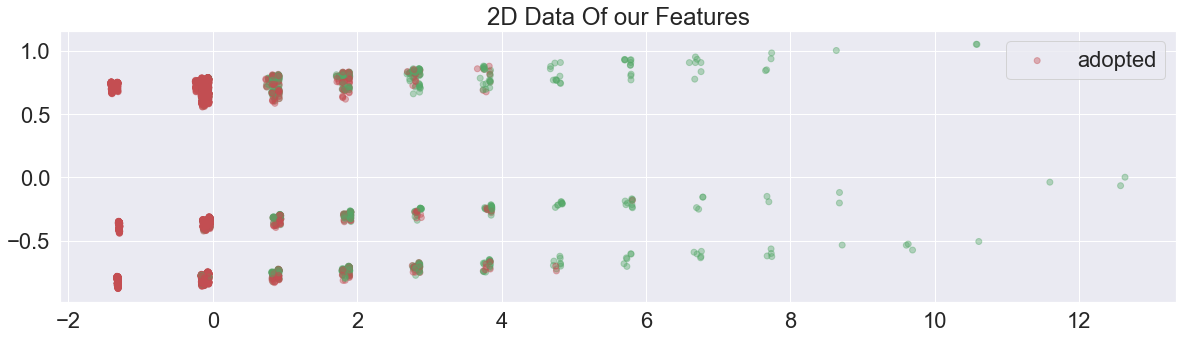

In [38]:
f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = plt.scatter(features_2d[:, 0], features_2d[:, 1], color=labels.color, alpha=0.4)
_ = a.set_title("2D Data Of our Features")
_ = a.legend(["adopted", "not adopted"])